# Quantum Gates

In [1]:
import numpy as np
from qutip import tensor, basis, ket2dm, average_gate_fidelity, Qobj
from qutip_qip.circuit import QubitCircuit
from chalmers_qubit.sarimner import *
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2

## Single Qubit Gate Example
We begin by creating a quantum circuit that has a single-qubit, and we perform a single-qubit gate on it

In [2]:
num_qubits = 1
circuit = QubitCircuit(num_qubits)
circuit.add_gate("RX", targets=0, arg_value=np.pi)

Next we define the hardware parameters that we will use when simulating this quantum circtuit. We therefore define a dictionary where the `key` corresponds to the qubit index and the value is another `dict` that can have the following values: 

- `frequency`: Qubit frequency in GHz.
- `anharmonicity`: Qubit anharmonicity in GHz.

We will also create another dict with the decoherence values for the qubit, the `key` needs to match the qubit index, and the value is another `dict` with the relaxation times

- `t1`: $T_1$ of the qubit in nano seconds.
- `t2`: $T_2$ of the qubit in nano seconds.

In [3]:
transmon_dict = {
    0: {"frequency": 5.0, "anharmonicity": -0.30},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 100e3},
}

Next we take these hardware parameters that we have defined and we load them into our superconducting hardware model `SarimnerModel`. The `SarimnerModel` along with the `SarimnerCompiler` and `noise` are given to `SarimnerProcessor` as shown in the figure below.

<div style="text-align: center;">
<img src="https://qutip-qip.readthedocs.io/en/stable/_images/structure.jpg" alt="Description of the image" width="500" height="300">
</div>

In [4]:
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Add noise
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

Once we have defined our processor we can load the quantum circuit onto the processor. This will compile the circuit into a pulse sequence.

In [5]:
tlist, coeffs = sarimner.load_circuit(circuit)

We can choose to plot the pulse sequence

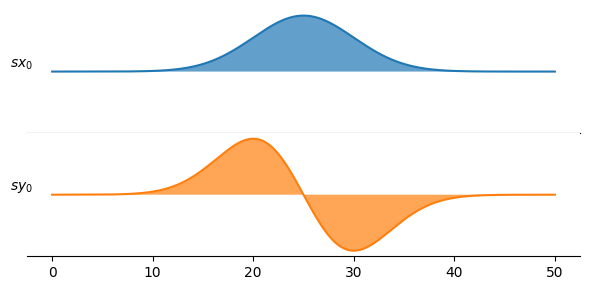

In [6]:
fig, ax = sarimner.plot_pulses(show_axis=True, figsize=(6,3));

Now we can exectue this pulse sequence on the processor by using `run_state` with a given `initial state`

In [7]:
initial_state = basis(3,0)
result = sarimner.run_state(initial_state)
final_state = result.states[-1]
final_state

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[3.96554225e-04-1.98591528e-18j 2.22678190e-04+2.08808013e-03j
  2.96776788e-08-4.78124282e-08j]
 [2.22678190e-04-2.08808013e-03j 9.99603313e-01-1.15655255e-18j
  3.14043979e-07-5.93582604e-08j]
 [2.96776787e-08+4.78124282e-08j 3.14043979e-07+5.93582604e-08j
  1.32725423e-07+1.73553864e-18j]]

Since we simulated the system for a three-level system we have to project it onto the computational subspace using the function `project_on_qubit`

In [8]:
project_on_qubit(final_state)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[3.96554225e-04-1.98591528e-18j 2.22678190e-04+2.08808013e-03j]
 [2.22678190e-04-2.08808013e-03j 9.99603313e-01-1.15655255e-18j]]

## Two Qubit Gate Example

Next we show a simple circuit using a two-qubit `CZ`-gate and how to compile it onto our processor.

In [32]:
# Define a circuit and run the simulation
num_qubits = 2
circuit = QubitCircuit(num_qubits)
circuit.add_gate("CZ", controls=0, targets=1)

Just as before we start by defining our hardware parameters.

In [33]:
transmon_dict = {
    0: {"frequency": 5.0, "anharmonicity": -0.30},
    1: {"frequency": 5.4, "anharmonicity": -0.30},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 80e3},
    1: {"t1": 100e3, "t2": 105e3},
}

Additionally we need to supply information of how the qubits are coupled together. This is done using another dictionary, where the value is supplied as a tuple `(i,j)` defining qubit $i$ and qubit $j$ and the value is the coupling strength in GHz.

In [34]:
# The time for the CZ-gate that we want in (ns)
t = 100

# Corresponding coupling in (GHz)
g = 1 / (np.sqrt(2) * 2 * t)

coupling_dict = {
    (0, 1): g,
}

and load them onto our model

In [53]:
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict, coupling_dict=coupling_dict)
# Options for compiler
options = {
    "dt": 0.1, # time-step of simulator in (ns)
    "two_qubit_gate": {
        "buffer_time": 10, # buffer-time of two-qubit gate in (ns)
        "rise_fall_time": 0, # sinusodial rise and fall time of two-qubit gate in (ns)
    },
}
# Choose compiler
compiler = SarimnerCompiler(model=model, options=options)
# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler)

Then we can compile the circuit onto our processor

In [54]:
tlist, coeffs = sarimner.load_circuit(circuit)

In [55]:
cz_real, cz_imag = coeffs["cz_real01"], coeffs["cz_imag01"]
cz = np.sqrt(cz_real**2 + cz_imag**2)
tlist_real, tlist_imag = tlist["cz_real01"], tlist["cz_imag01"]

In [56]:
np.trapz(cz, tlist_real)

100.0

In [ ]:
area = np.trapz(y=cz_real, x=tlist_real) + np.trapz(y=cz_real, x=tlist_real)

{'cz_real01': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.598e+02, 1.599e+02,
        1.600e+02]),
 'cz_imag01': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.598e+02, 1.599e+02,
        1.600e+02])}

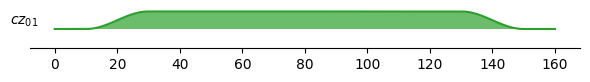

In [37]:
sarimner.plot_pulses(show_axis=True, figsize=(6,3));

To see that the CZ-gate is implemented correctly we will now simulate the circuit using the master equation simulation and look at the expectation values of the $|11\rangle$ and $|20\rangle$ states.

In [38]:
ket01 = tensor(basis(3,0), basis(3,1))
ket10 = tensor(basis(3,1), basis(3,0))
ket11 = tensor(basis(3,1), basis(3,1))
ket20 = tensor(basis(3,2), basis(3,0))
# List of operators we wanna compute the expectation value for during the simulation
e_ops = [ket2dm(ket01), ket2dm(ket10), ket2dm(ket11), ket2dm(ket20)]
result = sarimner.run_state(ket11, e_ops=e_ops, options={'nsteps': 1e5, 'store_final_state': True})

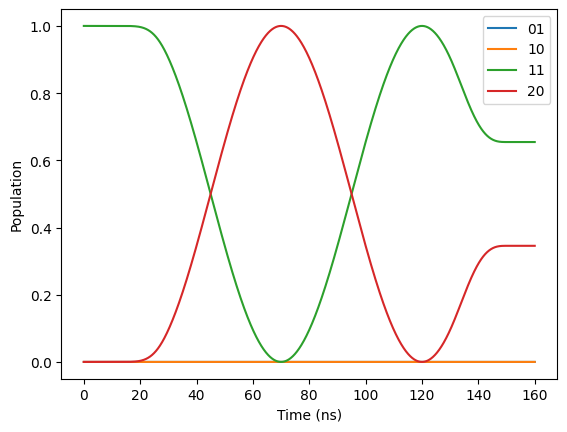

In [39]:
import matplotlib.pyplot as plt
plt.plot(result.times, result.expect[0], label="01")
plt.plot(result.times, result.expect[1], label="10")
plt.plot(result.times, result.expect[2], label='11')
plt.plot(result.times, result.expect[3], label='20')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend()

And if we print the final state we see that the $|11\rangle$ state has the desired $-1$ phase.

In [17]:
qubit_state = project_on_qubit(result.final_state)
qubit_state

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.j       ]
 [ 0.        +0.j       ]
 [ 0.        +0.j       ]
 [-0.99999761+0.0003081j]]

## Three Qubit Gate Example

Finally we will demonstrate the implementation of the three-qubit gate.

Since this gate is not part of qutip `QubitCircuit` we have to defined the gate ourself and supply as `user_gates`

In [18]:
from qutip import Qobj
# Ideal gate
def cczs(args):
    theta, phi, gamma = args
    U = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, -np.exp(-1j*gamma)*np.sin(theta/2)**2 + np.cos(theta/2)**2, 
                                    (1/2)*(1 + np.exp(-1j*gamma))*np.exp(-1j*phi)*np.sin(theta), 0],
                  [0, 0, 0, 0, 0, (1/2)*(1 + np.exp(-1j*gamma))*np.exp(1j*phi)*np.sin(theta), 
                                    -np.exp(-1j*gamma)*np.cos(theta/2)**2 + np.sin(theta/2)**2, 0],
                  [0, 0, 0, 0, 0, 0, 0, -np.exp(1j*gamma)]], dtype="complex")
    return Qobj(U, dims=[[2]*3, [2]*3])

Alternatively we can just import the gate from `chalmers_qubit.base.gates`

In [19]:
from chalmers_qubit.base.gates import cczs

In [20]:
# Define a circuit and run the simulation
num_qubits = 3

circuit = QubitCircuit(num_qubits)
circuit.user_gates = {"CCZS": cczs}
circuit.add_gate("CCZS", targets=[0,1,2], arg_value=[np.pi/2,0,0])

In [21]:
transmon_dict = {
            0: {"frequency": 5.0, "anharmonicity": 0.3},
            1: {"frequency": 5.4, "anharmonicity": 0.3},
            2: {"frequency": 5.2, "anharmonicity": 0.3},
        }

# Times in (ns)
t = 100

# corresponding coupling
g = 1 / (np.sqrt(2) * 2 * t)

coupling_dict = {(0, 1): g,
                 (0, 2): -g} # for phi=0 the coupling strengths need different signs

In [22]:
# Load the physical parameters onto the model
model = SarimnerModel(
    transmon_dict=transmon_dict,
    coupling_dict=coupling_dict
)
options = {
    "dt": 0.1,
    "two_qubit_gate": {
        "buffer_time": 0,
        "rise_fall_time": 0.1,
    },
}
# Choose compiler
compiler = SarimnerCompiler(model=model, options=options)
# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=[])

In [23]:
tlist, coeffs = sarimner.load_circuit(circuit)

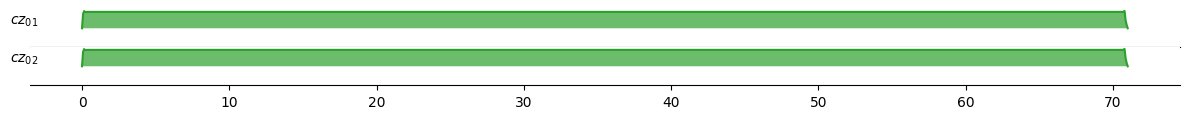

In [24]:
sarimner.plot_pulses(show_axis=True);

In [25]:
ket110 = tensor([basis(3,1),basis(3,1),basis(3,0)])
ket101 = tensor([basis(3,1),basis(3,0),basis(3,1)])
ket200 = tensor([basis(3,2),basis(3,0),basis(3,0)])
e_ops = [ket2dm(ket110), ket2dm(ket101), ket2dm(ket200)]
result = sarimner.run_state(ket110, e_ops=e_ops, options={'store_states':True, 'nsteps':1e5, 'atol': 1e-12})

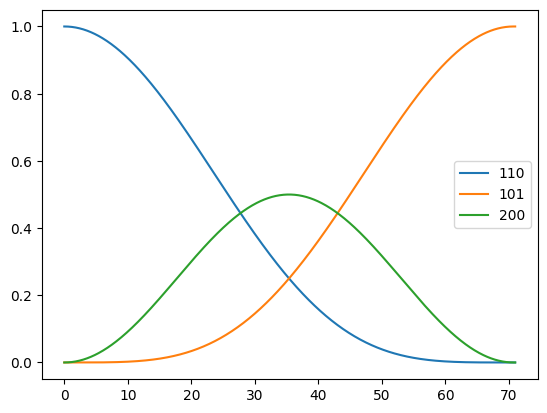

In [26]:
import matplotlib.pyplot as plt
plt.plot(result.times,result.expect[0], label="110")
plt.plot(result.times,result.expect[1], label="101")
plt.plot(result.times,result.expect[2], label="200")
plt.legend()

Using the `run_propagator` method we can compute the propagator of the evolution.

In [27]:
prop = sarimner.run_propagator(options={"nsteps":1e5})
prop = project_on_qubit(prop)
prop

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e

We can then compute the average gate fidelity between the ideal gate and the simulated gate

In [28]:
ideal_prop = cczs((np.pi / 2, 0, 0))
average_gate_fidelity(ideal_prop, prop)

0.999994069986429